In [1]:
from patchify import patchify
from transformers import SamModel, SamProcessor, SamConfig
import torch
from datasets import Dataset
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import random
import time
import cv2 as cv

from utils import *

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

In [2]:
paths = {
    'train': {'images':   r"data/sam_finetuning/train/images/",
              'masks':    r"data/sam_finetuning/train/masks/",
              'bboxes':   r"data/sam_finetuning/train/bboxes/"},
    'val':   {'images':   r"data/sam_finetuning/val/images/",
              'masks':    r"data/sam_finetuning/val/masks/",
              'bboxes':   r"data/sam_finetuning/val/bboxes/"},
    'test':  {'images':   r"data/sam_finetuning/test/images/",
              'masks':    r"data/sam_finetuning/test/masks/",
              'bboxes':   r"data/sam_finetuning/test/bboxes/"}
}

train_images = get_images(paths['train']['images'])
val_images   = get_images(paths['val']['images'])
test_images  = get_images(paths['test']['images'])

train_masks  = get_images(paths['train']['masks'])
val_masks    = get_images(paths['val']['masks'])
test_masks   = get_images(paths['test']['masks'])

train_bboxes = get_bboxes(paths['train']['bboxes'])
val_bboxes   = get_bboxes(paths['val']['bboxes'])
test_bboxes  = get_bboxes(paths['test']['bboxes'])

n_train = len(train_images)
n_val   = len(val_images)
n_test  = len(test_images)

print(f'num train_images: {n_train}')
print(f'num val_images: {n_val}')
print(f'num test_images: {n_test}')

original_dims = (512, 641)

num train_images: 411
num val_images: 102
num test_images: 101


In [3]:
nosat_images = get_images(r'data/nosat/')
nosat_masks = np.zeros((len(nosat_images), original_dims[0], original_dims[1], 3))
nosat_bboxes = [None] * len(nosat_images)
    
print(f'num nosat_images: {len(nosat_images)}')

num nosat_images: 101


In [4]:
train_dict = {
    'image': [Image.fromarray(img.astype('uint8')) for img in train_images.values()],
    'mask': [Image.fromarray(mask.astype('uint8')) for mask in train_masks.values()],
    'bbox': [(x, y, w, h) for (x, y), w, h in train_bboxes.values()],
}
val_dict = {
    'image': [Image.fromarray(img.astype('uint8')) for img in val_images.values()],
    'mask': [Image.fromarray(mask.astype('uint8')) for mask in val_masks.values()],
    'bbox': [(x, y, w, h) for (x, y), w, h in val_bboxes.values()],
}
test_dict = {
    'image': [Image.fromarray(img.astype('uint8')) for img in test_images.values()],
    'mask': [Image.fromarray(mask.astype('uint8')) for mask in test_masks.values()],
    'bbox': [(x, y, w, h) for (x, y), w, h in test_bboxes.values()],
}
nosat_dict = {
    'image': [Image.fromarray(img.astype('uint8')) for img in nosat_images.values()],
    'mask': [Image.fromarray(mask.astype('uint8')) for mask in nosat_masks],
    'bbox': nosat_bboxes,
}
combo_dict = {
    'image': test_dict['image'] + nosat_dict['image'],
    'mask': test_dict['mask'] + nosat_dict['mask'],
    'bbox': test_dict['bbox'] + nosat_dict['bbox'],
}

train_dataset = Dataset.from_dict(train_dict)
val_dataset   = Dataset.from_dict(val_dict)
test_dataset  = Dataset.from_dict(test_dict)
nosat_dataset = Dataset.from_dict(nosat_dict)
combo_dataset = Dataset.from_dict(combo_dict)

In [5]:
def resize_image(img_arr: np.ndarray, w: int, h: int) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize((w, h))
    return np.array(img)

In [6]:
# Get bounding boxes from mask. (FROM ONLINE SOURCE)
def get_bounding_box(ground_truth_map: np.ndarray) -> list[int]:
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [7]:
patch_size = 256
# image_size = 512

avg_train_area: 481.8905109489051
avg_val_area: 1120.6176470588234


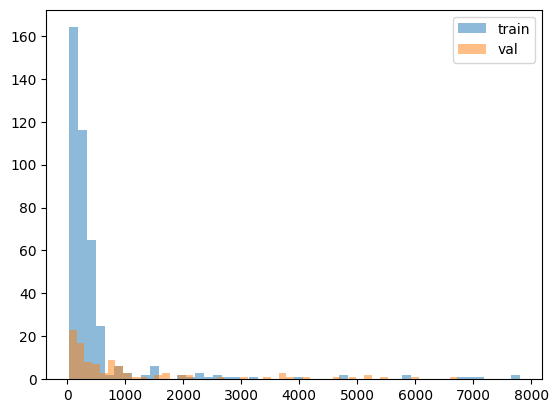

avg_train_area: 260.0703125
avg_val_area: 405.0


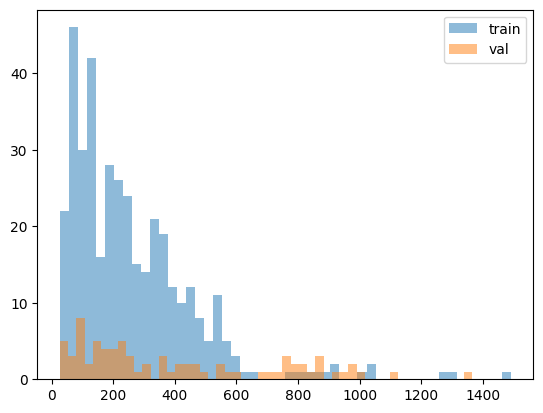

In [8]:
# Find average area of all training and validation masks
train_areas = []
val_areas = []
for key in train_masks:
    train_areas.append(np.sum(train_masks[key] > 0))
for key in val_masks:
    val_areas.append(np.sum(val_masks[key] > 0))

avg_train_area = np.mean(train_areas)
avg_val_area = np.mean(val_areas)
print("avg_train_area:", avg_train_area)
print("avg_val_area:", avg_val_area)

# plot train areas and val areas
plt.hist(train_areas, bins=50, alpha=0.5, label='train')
plt.hist(val_areas, bins=50, alpha=0.5, label='val')
plt.legend(loc='upper right')
plt.show()

# remove outliers from both areas lists
train_areas = [area for area in train_areas if area < 1500]
val_areas = [area for area in val_areas if area < 1500]

avg_train_area = np.mean(train_areas)
avg_val_area = np.mean(val_areas)
print("avg_train_area:", avg_train_area)
print("avg_val_area:", avg_val_area)
plt.hist(train_areas, bins=50, alpha=0.5, label='train')
plt.hist(val_areas, bins=50, alpha=0.5, label='val')
plt.legend(loc='upper right')
plt.show()


In [9]:
checkpoints_dir = 'finetuned_sam_checkpoints/512_checkpoints_balanced/'
pattern = os.path.join(checkpoints_dir, '*.pt')
file_list = glob.glob(pattern)

sam_model_paths = {}
for file_path in file_list:
    file_path = file_path.replace('\\', '/')
    epoch_num = int(file_path.split('_')[-1][:-3])
    sam_model_paths[epoch_num] = file_path
sam_model_paths = {k: v for (k, v) in sorted(sam_model_paths.items(), key=lambda x: x[0])}
sam_model_paths

{1: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_1.pt',
 2: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_2.pt',
 3: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_3.pt',
 4: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_4.pt',
 5: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_5.pt',
 6: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_6.pt',
 7: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_7.pt',
 8: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_8.pt',
 9: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_9.pt',
 10: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_10.pt',
 11: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_11.pt',
 12: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_12.pt',
 13: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_13.pt',
 14: 'finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_14.pt',
 15: 'finetuned_sam_chec

In [10]:
from src.segment_sat import SegmentSat

In [11]:
def load_segmentset(epoch: int):
    path = sam_model_paths[epoch]
    print("Loading model from path:", path)
    return SegmentSat(sam_model_path=path, 
                      vit_classifier_path='results/train_and_val/checkpoint-660')

segment_sat = load_segmentset(2)

Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_2.pt


c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tot_dist 2.670905984249283e+19
tot_dist 2023671525671.1648
tot_dist 8031048687301.097
tot_dist 978177427043605.8
IoU: 0.776595744680851
Correctly segmented!


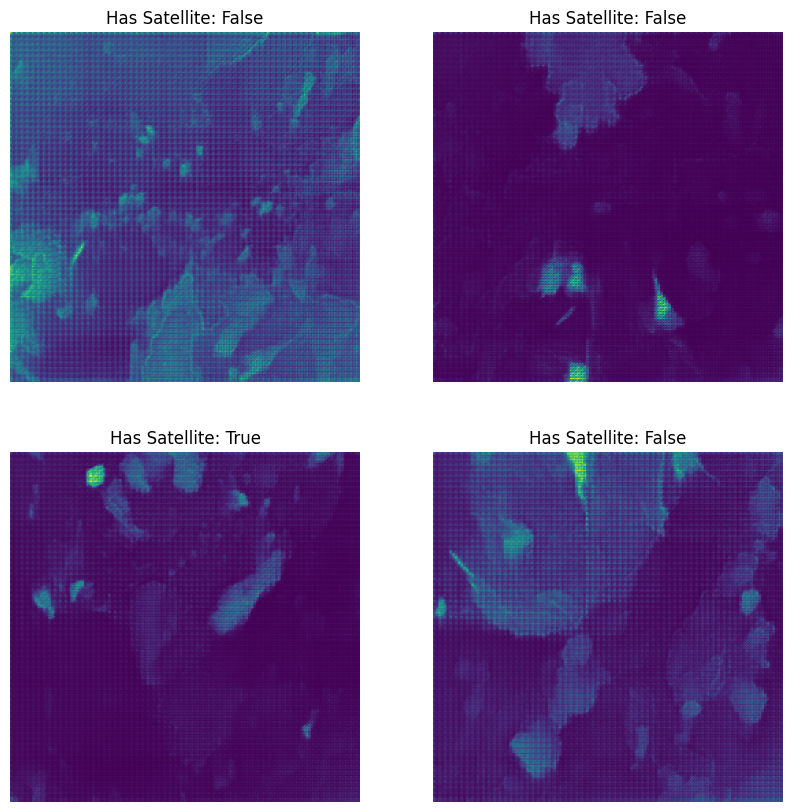

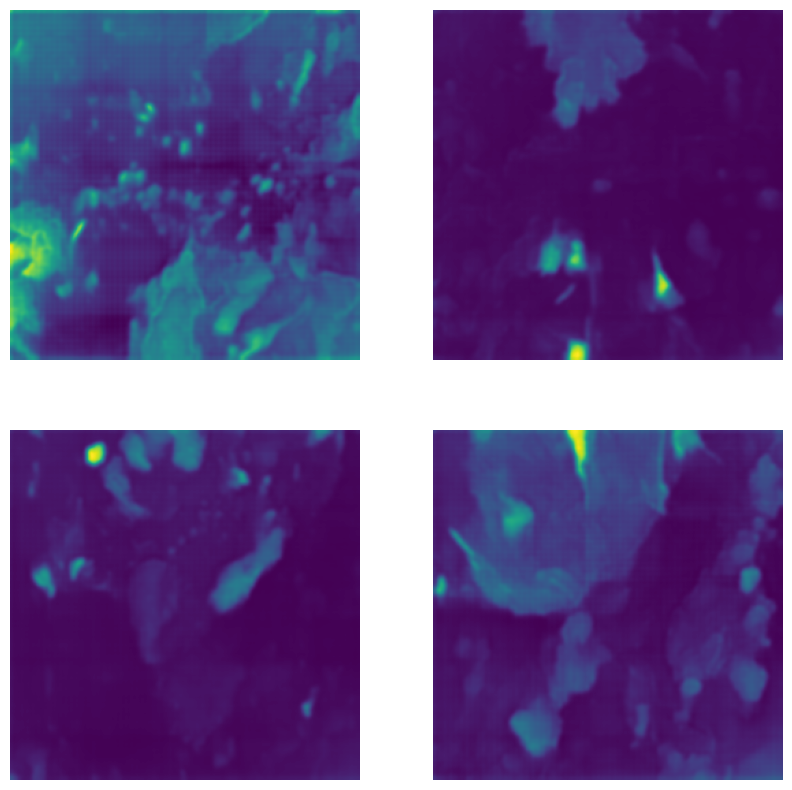

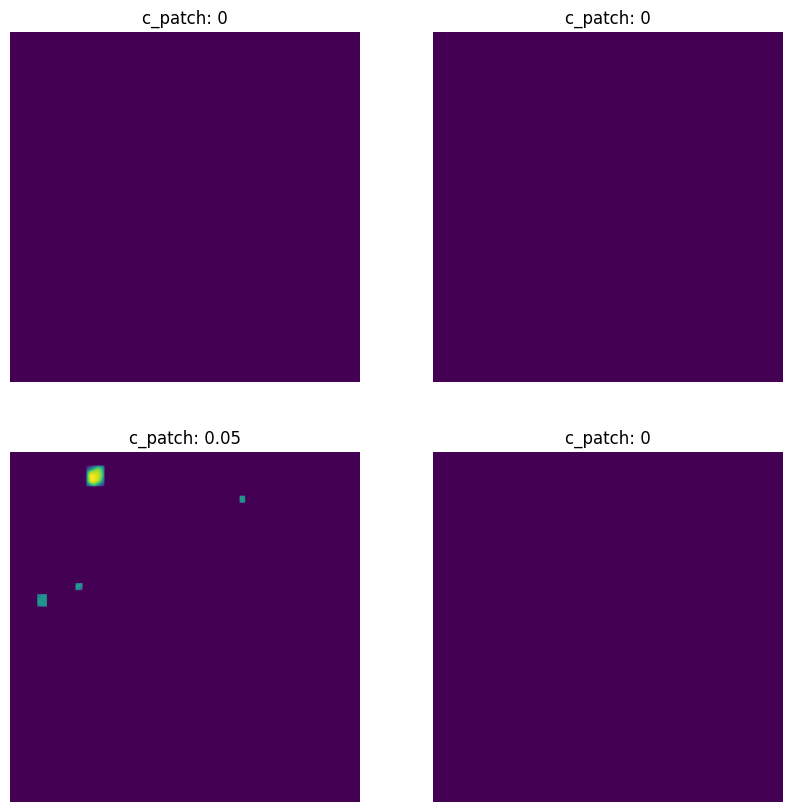

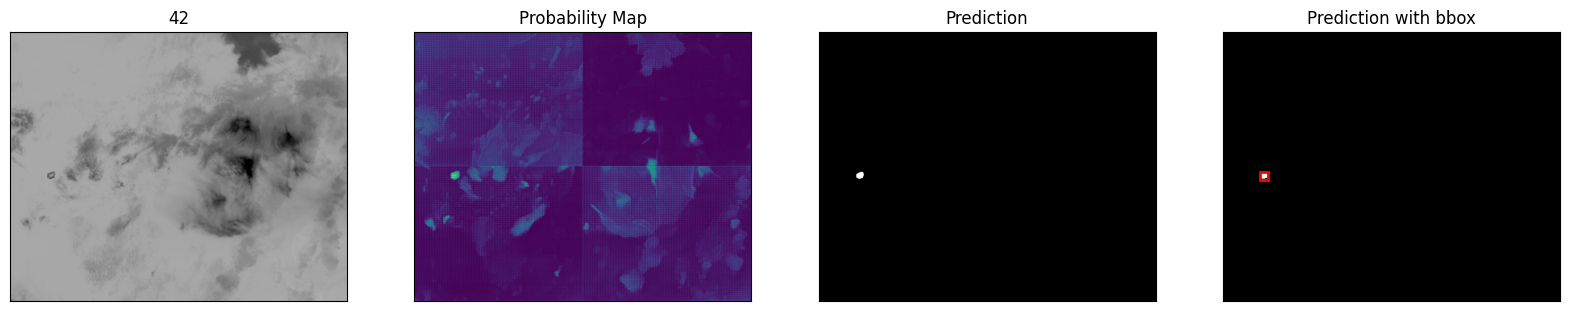

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0.259519  , 0.19268942, 0.13782632, ..., 0.01940001, 0.01309122,
         0.03550792],
        [0.17767826, 0.15023106, 0.1192118 , ..., 0.01929178, 0.01835141,
         0.0171294 ],
        [0.10523827, 0.09959074, 0.09355231, ..., 0.00952721, 0.00698578,
         0.01526621],
        ...,
        [0.14456888, 0.15978305, 0.12992193, ..., 0.1063873 , 0.0881981 ,
         0.08070666],
        [0.06922718, 0.12936245, 0.1096097 , ..., 0.08962163, 0.07559199,
         0.11069645],
        [0.1302971 , 0.11113894, 0.09252345, ..., 0.09861434, 0.09973195,
         0.09962917]], dtype=float32))

In [12]:
# segment_sat.sample_prediction(val_dataset, verbose=True, idx=14)
segment_sat.sample_prediction(val_dataset, verbose=False)

In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# Test different threshs on val set
threshs = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
val_accs_thresh = []
for thresh in threshs:
    print(f"Testing thresh = {thresh}")
    val_acc_thresh, _ = segment_sat.calc_accuracy(val_dataset, thresh=thresh)
    val_accs_thresh.append(val_acc_thresh)
    print(f"Val Acc: {val_acc_thresh}\n")

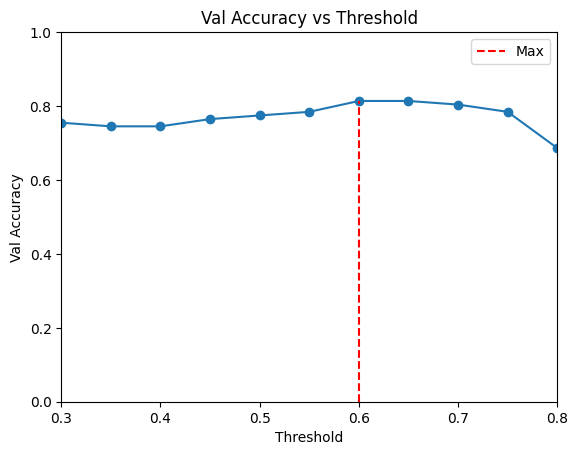

In [ ]:
plt.plot(threshs, val_accs_thresh)
plt.scatter(threshs, val_accs_thresh)

max_thresh = threshs[np.argmax(val_accs_thresh)]
max_acc_thresh = max(val_accs_thresh)

plt.plot([max_thresh, max_thresh], [0, max_acc_thresh], 'r--', label='Max')

plt.xlabel('Threshold')
plt.ylabel('Val Accuracy')
plt.title('Val Accuracy vs Threshold')
plt.ylim(0, 1)
plt.xlim(0.3, 0.8)
plt.legend()
plt.show()

In [ ]:
# Test different epochs
epochs = np.arange(1, 16)
val_accs_epoch = []

for epoch in epochs:
    print(f"Testing epoch = {epoch}")
    segment_sat_epoch = load_segmentset(epoch)
    val_epoch_acc, _ = segment_sat_epoch.calc_accuracy(val_dataset, thresh=max_thresh)
    val_accs_epoch.append(val_epoch_acc)
    print(f"Val Acc: {val_epoch_acc}\n")

Testing epoch = 1
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_1.pt


100%|██████████| 102/102 [01:01<00:00,  1.65it/s]


Val Acc: 0.5294117647058824

Testing epoch = 2
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_2.pt


100%|██████████| 102/102 [01:01<00:00,  1.67it/s]


Val Acc: 0.8431372549019608

Testing epoch = 3
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_3.pt


100%|██████████| 102/102 [01:00<00:00,  1.68it/s]


Val Acc: 0.8137254901960784

Testing epoch = 4
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_4.pt


100%|██████████| 102/102 [01:00<00:00,  1.69it/s]


Val Acc: 0.8137254901960784

Testing epoch = 5
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_5.pt


100%|██████████| 102/102 [01:00<00:00,  1.67it/s]


Val Acc: 0.8333333333333334

Testing epoch = 6
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_6.pt


100%|██████████| 102/102 [01:01<00:00,  1.67it/s]


Val Acc: 0.7843137254901961

Testing epoch = 7
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_7.pt


100%|██████████| 102/102 [01:01<00:00,  1.66it/s]


Val Acc: 0.803921568627451

Testing epoch = 8
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_8.pt


100%|██████████| 102/102 [01:01<00:00,  1.67it/s]


Val Acc: 0.6666666666666666

Testing epoch = 9
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_9.pt


100%|██████████| 102/102 [01:01<00:00,  1.66it/s]


Val Acc: 0.8333333333333334

Testing epoch = 10
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_10.pt


100%|██████████| 102/102 [01:00<00:00,  1.67it/s]


Val Acc: 0.8137254901960784

Testing epoch = 11
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_11.pt


100%|██████████| 102/102 [01:01<00:00,  1.67it/s]


Val Acc: 0.8137254901960784

Testing epoch = 12
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_12.pt


100%|██████████| 102/102 [01:00<00:00,  1.68it/s]


Val Acc: 0.803921568627451

Testing epoch = 13
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_13.pt


100%|██████████| 102/102 [01:00<00:00,  1.68it/s]


Val Acc: 0.8431372549019608

Testing epoch = 14
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_14.pt


100%|██████████| 102/102 [01:01<00:00,  1.65it/s]


Val Acc: 0.8235294117647058

Testing epoch = 15
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_15.pt


100%|██████████| 102/102 [01:01<00:00,  1.67it/s]

Val Acc: 0.7843137254901961



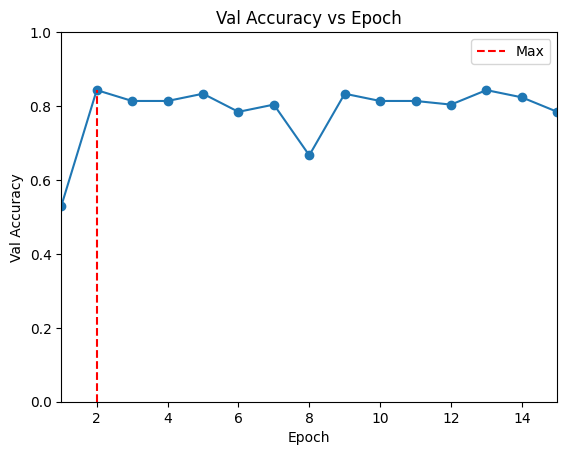

In [ ]:
plt.plot(epochs, val_accs_epoch)
plt.scatter(epochs, val_accs_epoch)

max_epoch = epochs[np.argmax(val_accs_epoch)]
max_acc_epoch = max(val_accs_epoch)

plt.plot([max_epoch, max_epoch], [0, max_acc_epoch], 'r--', label='Max')

plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.title('Val Accuracy vs Epoch')
plt.ylim(0, 1)
plt.xlim(1, 15)
plt.legend()
plt.show()

In [ ]:
# Test different epochs
epochs = np.arange(1, 16)
train_accs_epoch = []

for epoch in epochs:
    print(f"Epoch = {epoch}")
    segment_sat_epoch = load_segmentset(epoch)
    train_acc_epoch, _ = segment_sat_epoch.calc_accuracy(train_dataset, thresh=max_thresh)
    train_accs_epoch.append(train_acc_epoch)
    print(f"Train Acc: {train_acc_epoch}\n")

Epoch = 1
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_1.pt


c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
100%|██████████| 411/411 [04:02<00:00,  1.69it/s]


Train Acc: 0.4233576642335766

Epoch = 2
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_2.pt


100%|██████████| 411/411 [04:01<00:00,  1.70it/s]


Train Acc: 0.7639902676399026

Epoch = 3
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_3.pt


100%|██████████| 411/411 [04:01<00:00,  1.70it/s]


Train Acc: 0.7664233576642335

Epoch = 4
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_4.pt


100%|██████████| 411/411 [04:01<00:00,  1.70it/s]


Train Acc: 0.7615571776155717

Epoch = 5
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_5.pt


100%|██████████| 411/411 [04:05<00:00,  1.68it/s]


Train Acc: 0.7518248175182481

Epoch = 6
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_6.pt


100%|██████████| 411/411 [04:05<00:00,  1.67it/s]


Train Acc: 0.7591240875912408

Epoch = 7
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_7.pt


100%|██████████| 411/411 [04:04<00:00,  1.68it/s]


Train Acc: 0.7420924574209246

Epoch = 8
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_8.pt


100%|██████████| 411/411 [04:05<00:00,  1.68it/s]


Train Acc: 0.7274939172749392

Epoch = 9
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_9.pt


100%|██████████| 411/411 [04:06<00:00,  1.67it/s]


Train Acc: 0.7956204379562044

Epoch = 10
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_10.pt


100%|██████████| 411/411 [04:04<00:00,  1.68it/s]


Train Acc: 0.7858880778588808

Epoch = 11
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_11.pt


100%|██████████| 411/411 [04:06<00:00,  1.67it/s]


Train Acc: 0.7153284671532847

Epoch = 12
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_12.pt


100%|██████████| 411/411 [04:03<00:00,  1.69it/s]


Train Acc: 0.805352798053528

Epoch = 13
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_13.pt


100%|██████████| 411/411 [04:04<00:00,  1.68it/s]


Train Acc: 0.7883211678832117

Epoch = 14
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_14.pt


100%|██████████| 411/411 [04:04<00:00,  1.68it/s]


Train Acc: 0.7591240875912408

Epoch = 15
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_15.pt


100%|██████████| 411/411 [04:03<00:00,  1.69it/s]

Train Acc: 0.829683698296837



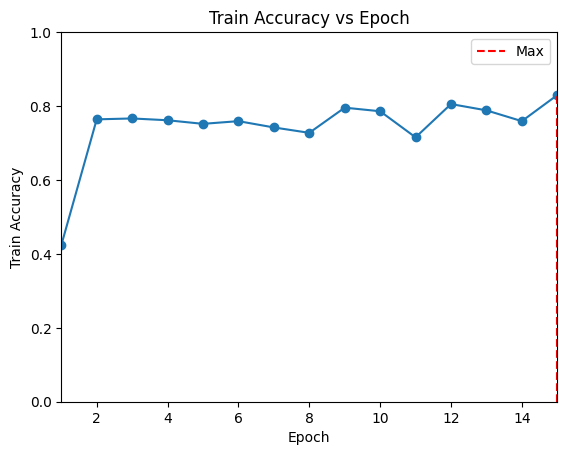

In [ ]:
plt.plot(epochs, train_accs_epoch)
plt.scatter(epochs, train_accs_epoch)

max_epoch = epochs[np.argmax(train_accs_epoch)]
max_train_acc_epoch = max(train_accs_epoch)

plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Epoch')
plt.ylim(0, 1)
plt.xlim(1, 15)
plt.legend()
plt.show()

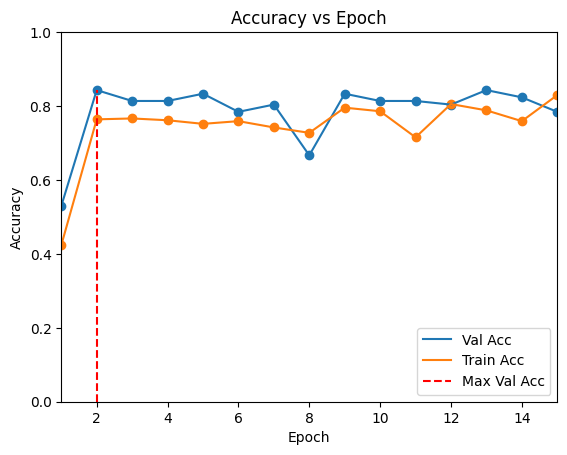

In [ ]:
plt.plot(epochs, val_accs_epoch, label='Val Acc')
plt.scatter(epochs, val_accs_epoch)

plt.plot(epochs, train_accs_epoch, label='Train Acc')
plt.scatter(epochs, train_accs_epoch)

max_epoch = epochs[np.argmax(val_accs_epoch)]
max_acc_epoch = max(val_accs_epoch)

plt.plot([max_epoch, max_epoch], [0, max_acc_epoch], 'r--', label='Max Val Acc')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0, 1)
plt.xlim(1, 15)
plt.legend()
plt.show()

In [ ]:
# Test different epochs
epochs = np.arange(1, 16)
combo_accs_epoch = []

for epoch in epochs:
    print(f"Epoch = {epoch}")
    segment_sat_epoch = load_segmentset(epoch)
    combo_acc_epoch, _ = segment_sat_epoch.calc_accuracy(combo_dataset, thresh=max_thresh)
    combo_accs_epoch.append(combo_acc_epoch)
    print(f"Combo Acc: {combo_acc_epoch}\n")

Epoch = 1
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_1.pt


c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
100%|██████████| 202/202 [02:00<00:00,  1.67it/s]


Combo Acc: 0.6237623762376238

Epoch = 2
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_2.pt


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


Combo Acc: 0.7821782178217822

Epoch = 3
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_3.pt


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


Combo Acc: 0.7772277227722773

Epoch = 4
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_4.pt


100%|██████████| 202/202 [01:59<00:00,  1.69it/s]


Combo Acc: 0.7821782178217822

Epoch = 5
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_5.pt


100%|██████████| 202/202 [01:59<00:00,  1.69it/s]


Combo Acc: 0.7871287128712872

Epoch = 6
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_6.pt


100%|██████████| 202/202 [01:58<00:00,  1.71it/s]


Combo Acc: 0.7673267326732673

Epoch = 7
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_7.pt


100%|██████████| 202/202 [01:58<00:00,  1.70it/s]


Combo Acc: 0.7524752475247525

Epoch = 8
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_8.pt


100%|██████████| 202/202 [01:58<00:00,  1.70it/s]


Combo Acc: 0.7475247524752475

Epoch = 9
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_9.pt


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


Combo Acc: 0.7970297029702971

Epoch = 10
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_10.pt


100%|██████████| 202/202 [01:59<00:00,  1.69it/s]


Combo Acc: 0.7821782178217822

Epoch = 11
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_11.pt


100%|██████████| 202/202 [01:57<00:00,  1.72it/s]


Combo Acc: 0.7623762376237624

Epoch = 12
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_12.pt


100%|██████████| 202/202 [01:57<00:00,  1.71it/s]


Combo Acc: 0.7871287128712872

Epoch = 13
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_13.pt


100%|██████████| 202/202 [01:59<00:00,  1.69it/s]


Combo Acc: 0.7821782178217822

Epoch = 14
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_14.pt


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


Combo Acc: 0.7772277227722773

Epoch = 15
Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_15.pt


100%|██████████| 202/202 [01:58<00:00,  1.71it/s]

Combo Acc: 0.7772277227722773



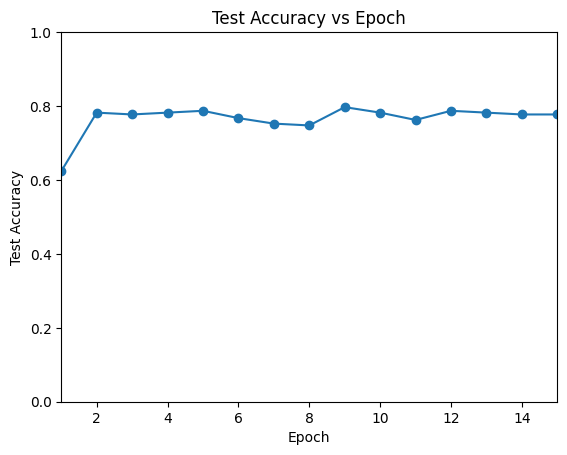

In [ ]:
plt.plot(epochs, combo_accs_epoch)
plt.scatter(epochs, combo_accs_epoch)

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.ylim(0, 1)
plt.xlim(1, 15)
plt.show()

In [ ]:
segment_sat_max = load_segmentset(2)

Loading model from path: finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_2.pt


In [ ]:
combo_res = segment_sat_max.calc_accuracy(combo_dataset, thresh=0.6)
print(combo_res)

100%|██████████| 202/202 [01:59<00:00,  1.70it/s]

(0.7821782178217822, 0.8236912581118184, {'precision': 0.8404255319148937, 'recall': 0.9186046511627907, 'tp': 158, 'fp': 30, 'fn': 14})


In [ ]:
test_res = segment_sat_max.calc_accuracy(test_dataset, thresh=0.6)
print(test_res)

100%|██████████| 101/101 [00:59<00:00,  1.70it/s]

(0.8613861386138614, 0.8236912581118184, {'precision': 1.0, 'recall': 0.8613861386138614, 'tp': 87, 'fp': 0, 'fn': 14})


In [ ]:
train_res = segment_sat_max.calc_accuracy(train_dataset, thresh=0.6)
print(train_res)

100%|██████████| 411/411 [04:06<00:00,  1.67it/s]

(0.7639902676399026, 0.7999348983071095)


In [ ]:
val_res = segment_sat_max.calc_accuracy(val_dataset, thresh=0.6)
print(val_res)

100%|██████████| 102/102 [01:01<00:00,  1.67it/s]

(0.8431372549019608, 0.8255897837626829, {'precision': 1.0, 'recall': 0.8431372549019608, 'tp': 86, 'fp': 0, 'fn': 16})


In [ ]:
nosat_acc, nosat_mIoU = segment_sat.calc_accuracy(nosat_dataset, thresh=0.65)
print(nosat_acc, nosat_mIoU)

100%|██████████| 101/101 [00:58<00:00,  1.71it/s]

0.7029702970297029 nan



c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import pandas as pd
data = {
    'Dataset': ['Train', 'Val', 'Test', 'NoSat', 'Combo'],
    'Accuracy': [train_acc, val_acc, test_acc, nosat_acc, combo_acc],
    'mIoU': [train_mIoU, val_mIoU, test_mIoU, nosat_mIoU, combo_mIoU]
}
df = pd.DataFrame(data)
print(df)

  Dataset  Accuracy      mIoU
0   Train  0.807786  0.794255
1     Val  0.813725  0.821548
2    Test  0.871287  0.800072
3   NoSat  0.702970       NaN
4   Combo  0.787129  0.800072


In [ ]:
checkpoints_dir = '../finetuned_sam_checkpoints/512_checkpoints_balanced_better/'
pattern = os.path.join(checkpoints_dir, '*.pt')
file_list = glob.glob(pattern)

max_epochs = 15

epochs = np.arange(1, max_epochs + 1)
training_losses = np.zeros(max_epochs)

for file_path in file_list:
    file_path = file_path.replace('\\', '/')
    epoch_num = int(file_path.split('_')[-1][:-3])
    
    if epoch_num != max_epochs:
        continue
    
    checkpoint = torch.load(file_path)
    tr_loss = checkpoint['tr_metrics']
    
    for e, d in tr_loss.items():
        training_losses[e - 1] = d['loss']


plt.plot(epochs, training_losses)

In [14]:
def mask_within_bbox(mask, bbox: tuple[tuple[int, int], int, int], thresh: float = 0.5) -> bool:
    mask_img = np.array(mask, dtype=np.uint8)
    tot_area = np.sum(mask_img)
    
    x, y, w, h = bbox
    
    area_in_bbox = 0
    for dw in range(w):
        for dh in range(h):
            if mask_img[y + dh, x + dw] == 1:
                area_in_bbox += 1

    return area_in_bbox / tot_area >= thresh, area_in_bbox / tot_area


def joint_intersection(mask1, mask2, thresh) -> bool:
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    if union.sum() == 0:
        return True, 0
    return np.sum(intersection) / np.sum(union) >= thresh, np.sum(intersection) / np.sum(union)


def plot_prediction(image: np.ndarray, prediction: np.ndarray, probability: np.ndarray, idx: int, bbox: tuple = None, ratio: float = None, is_correct=None) -> None:
    if bbox:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    else:
        fix, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title(f"Image {idx}")

    # Plot the second image on the right
    axes[1].imshow(probability)  # Assuming the second image is grayscale
    axes[1].set_title("Probability Map")

    # Plot the second image on the right
    axes[2].imshow(prediction, cmap='gray')  # Assuming the second image is grayscale

    axes[2].set_title(f"Prediction - {'Correct' if is_correct else 'Incorrect'}")
    
    if bbox:
        axes[3].imshow(prediction, cmap='gray') 
        axes[3].set_title("Prediction with bbox")
        
        x, y, w, h = bbox
        r = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[3].add_patch(r)

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()
    
    plt.imshow(prediction, cmap='gray')  # Assuming the second image is grayscale
    plt.title("Prediction")
    if ratio: plt.title(f"Prediction IoU: {round(ratio, 2)}")
    plt.axis('off')
    plt.show()
        

def resize_image(img_arr: np.ndarray, w: int, h: int) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize((w, h))
    return np.array(img)


def prepare_image(image: np.ndarray, dims: tuple[int, int], patch_size: int, verbose=True) -> torch.Tensor:
    start_time = time.time()
    
    image = resize_image(image, dims[0], dims[1])
    patches = patchify(np.array(image), (patch_size, patch_size, 3), step=256)
    patches = np.squeeze(patches)
    
    end_time = time.time()
    
    if verbose:
        print(f"Time taken to prepare image: {end_time - start_time:.2f} seconds")
    
    return patches


def visualize_full_pipeline(seg_sat, dataset, thresh=0.6, idx: int = None, verbose=False, iou_or_bbox: str = 'iou'):
    idx = random.randint(0, len(dataset)-1) if not idx else idx
    
    item = dataset[idx]
    image = np.array(item['image'])
    bbox = item['bbox']
    mask = np.array(item['mask'])

    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    patches = prepare_image(image, (512, 512), patch_size=256, verbose=verbose)
    
    fig, axs = plt.subplots(patches.shape[0], patches.shape[1], figsize=(10, 10))
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j]
            axs[i, j].imshow(cv.cvtColor(patch, cv.COLOR_BGR2RGB))
            axs[i, j].axis('off')  # Hide axes
    
    plt.show()
    
    mask_pred, mask_prob = seg_sat.predict(image, thresh, verbose=verbose)

    within, ratio = False, 0
    if iou_or_bbox == 'bbox':
        within, ratio = mask_within_bbox(mask_pred, bbox)
    elif iou_or_bbox == 'iou':
        within, ratio = joint_intersection(mask_pred, mask[:, :, 0], 0.5)
        
    print("IoU:", ratio)
    if within:
        print("Correctly segmented!")
    else:
        print("Incorrectly segmented.")

    plot_prediction(image, mask_pred, mask_prob, idx, None, ratio, within)
    
    return mask_pred, mask_prob

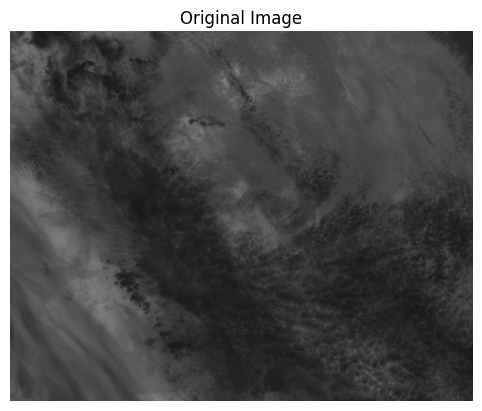

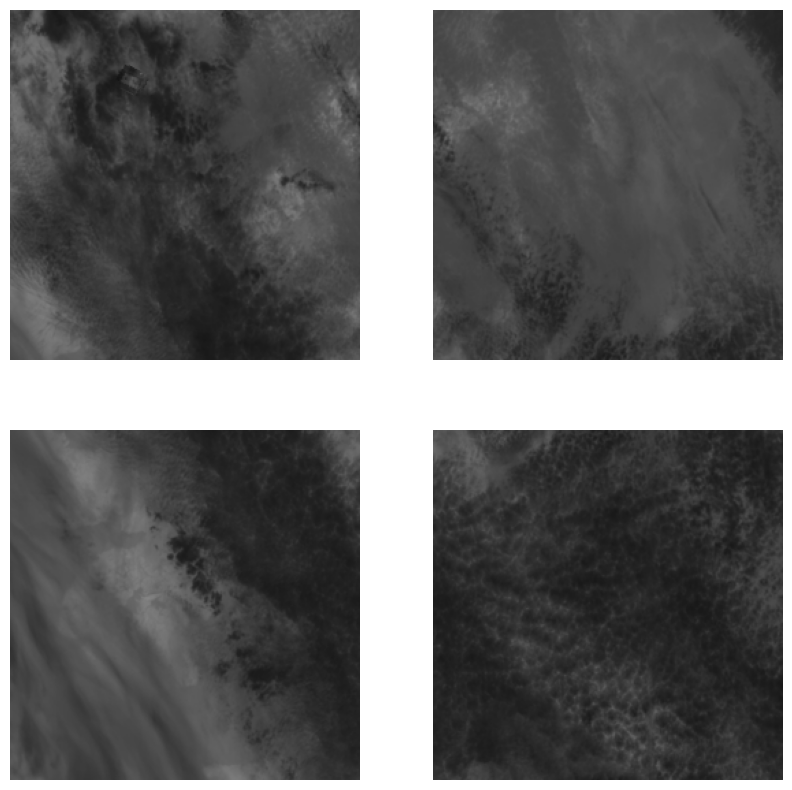

tot_dist 63032353949997.625
tot_dist 1.3886159994090308e+19
tot_dist 2.157430064621731e+19
tot_dist 7.963906483078889e+18
IoU: 0.6781857451403888
Correctly segmented!


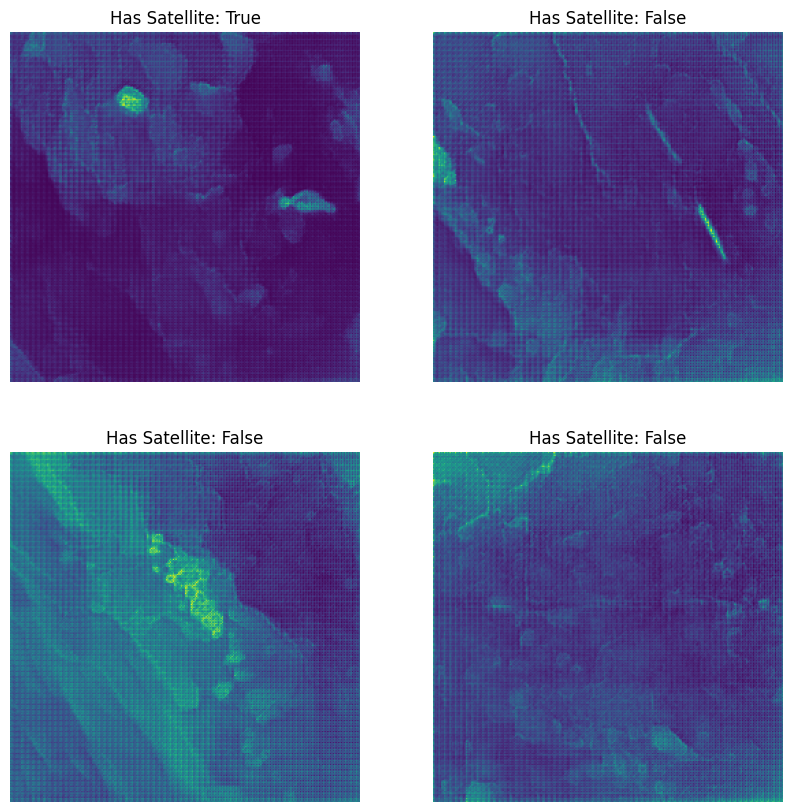

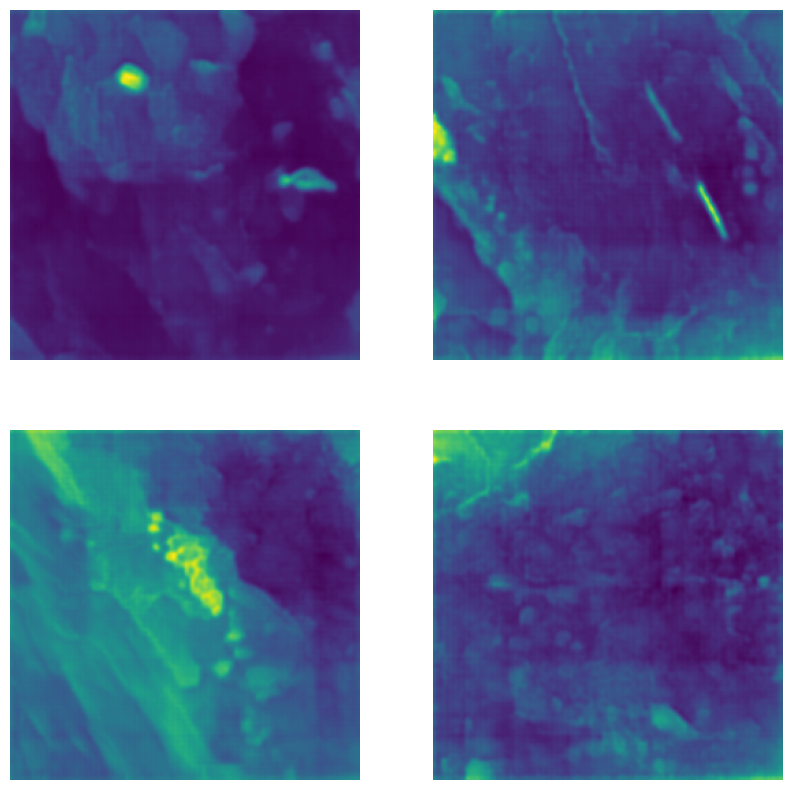

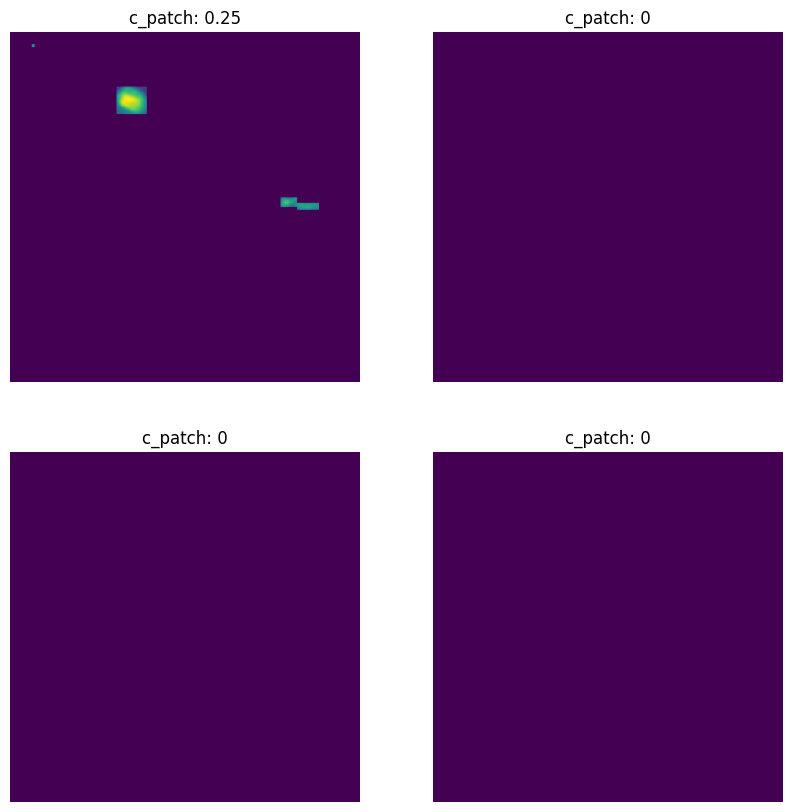

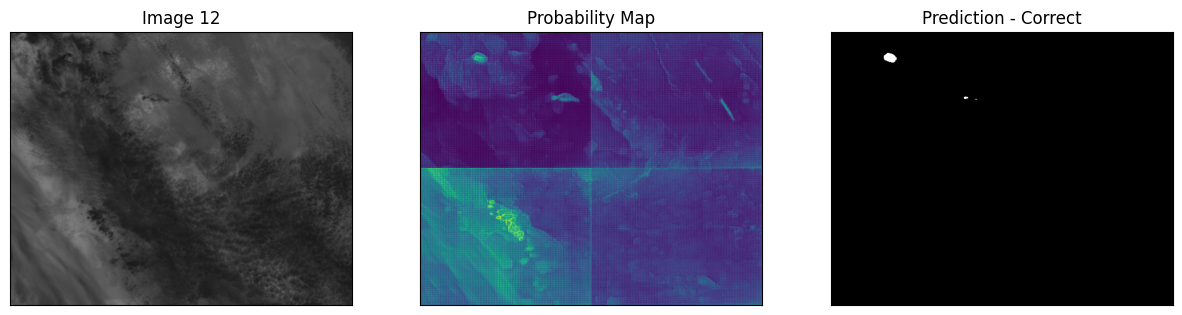

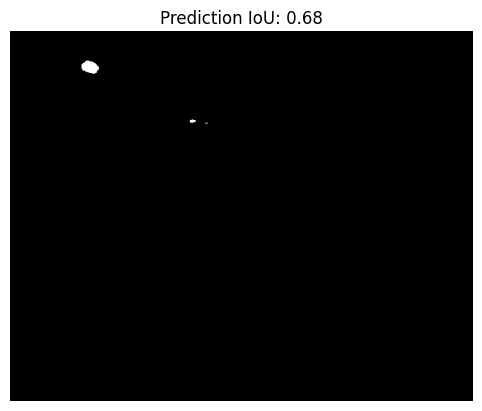

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0.15675537, 0.13760243, 0.1026635 , ..., 0.10737313, 0.08480208,
         0.13632941],
        [0.132014  , 0.108258  , 0.08688435, ..., 0.09402246, 0.09263077,
         0.11703359],
        [0.06402239, 0.06991478, 0.06447461, ..., 0.07488199, 0.07571931,
         0.10557808],
        ...,
        [0.23168507, 0.22871806, 0.19569753, ..., 0.16454384, 0.14968996,
         0.15902677],
        [0.16512191, 0.19691227, 0.17554772, ..., 0.1697185 , 0.15836133,
         0.19824335],
        [0.21582463, 0.18902731, 0.17081164, ..., 0.17888919, 0.16275333,
         0.17765966]], dtype=float32))

In [32]:
visualize_full_pipeline(segment_sat, test_dataset, thresh=0.6, verbose=False, idx=12, iou_or_bbox='iou')